# Music Retrieval / Audio Identification

**Course:** Introduction to Information Retrieval (194.166)

**Milestone 2.2:** Fingerprint Matching

**Group:** 26

| Student Name           | Student ID |
|------------------------|------------|
| Nikita Lysenko         | 12127033   |
| Yagmur Coban           | 12313405   |
| Nikolaus Winkelhofer  | 12317833   |

Steps done here:

1. Compute spectrogram (STFT magnitude)
2. Compute constellation map (peak picking)
3. Extract peaks (time, frequency, magnitude)
4. Generate **anchor–target hashes** inside configurable **target zones**
5. Store hashes in an **inverted index**: `hash -> [(track_id, time_offset), ...]`
6. Save the database and a small report (hash counts + file sizes)


In [37]:
# Imports
import os
import glob
import time
import pickle
from collections import defaultdict

import numpy as np
import pandas as pd
import librosa
from scipy import ndimage

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')


## Configuration

Edit `BASE_PATH`, `DB_AUDIO_PATH`, and `OUTPUT_*` to match your machine.

- `DB_AUDIO_PATH` should point to the folder containing the database tracks.
- The code supports `.mp3`, `.wav`, `.m4a`.


In [38]:
# Paths
BASE_PATH = r"C:\5Semester\IR\Milestone2\MS_2.2"
DB_AUDIO_PATH = os.path.join(BASE_PATH, "raw_30s_audio-26/26")

# Output folder for Task 1
OUTPUT_DIR = os.path.join(BASE_PATH, "task1_hash_db")
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPUT_DB_FILE = os.path.join(OUTPUT_DIR, "hash_db.pkl")
OUTPUT_REPORT_CSV = os.path.join(OUTPUT_DIR, "hash_db_report.csv")

print("DB_AUDIO_PATH:", DB_AUDIO_PATH)
print("OUTPUT_DB_FILE:", OUTPUT_DB_FILE)
print("OUTPUT_REPORT_CSV:", OUTPUT_REPORT_CSV)


DB_AUDIO_PATH: C:\5Semester\IR\Milestone2\MS_2.2\raw_30s_audio-26/26
OUTPUT_DB_FILE: C:\5Semester\IR\Milestone2\MS_2.2\task1_hash_db\hash_db.pkl
OUTPUT_REPORT_CSV: C:\5Semester\IR\Milestone2\MS_2.2\task1_hash_db\hash_db_report.csv


## Parameters

- **Peak picking**: we reuse the best-performing configuration from MS1: `dist_freq=12`, `dist_time=6`, `thresh=0.01`.
- **Target zones**: four configurations using two frequency ranges × two time ranges (in frames).

> Note: time windows are expressed in **frames**, because hashes are based on the time-frame index from the STFT.


In [39]:
# --- STFT parameters ---
Fs = 22050
N = 2048
H = 1024

# --- Peak picking parameters ---
PEAK_DIST_FREQ = 12
PEAK_DIST_TIME = 6
PEAK_THRESH = 0.01

# restrict bins to fit into 10-bit frequency (0..1023) cleanly
# N=2048 produces 1025 bins (0..1024). Setting BIN_MAX=1024 drops the Nyquist bin.
BIN_MAX = 1024

# --- Target zones (two freq ranges × two time ranges) ---
TARGET_ZONES = [
    {"name": "Fsmall_Tshort", "df": 50,  "dt_min": 1, "dt_max": 20},
    {"name": "Fsmall_Tlong",  "df": 50,  "dt_min": 1, "dt_max": 60},
    {"name": "Flarge_Tshort", "df": 150, "dt_min": 1, "dt_max": 20},
    {"name": "Flarge_Tlong",  "df": 150, "dt_min": 1, "dt_max": 60},
]

# limits number of target peaks per anchor (makes index size smaller)
TOP_K_TARGETS = 5  # can be set to None to disable

# Duration handling:
# - Use None for full track (needed in MS2.2 Task 3 scaling)
LOAD_DURATION = 30.0

sec_per_frame = H / Fs
print(f"sec_per_frame = {sec_per_frame:.5f} s")
print("Target zones:")
for z in TARGET_ZONES:
    print(" ", z, f"(~dt_max {z['dt_max']*sec_per_frame:.2f}s)")


sec_per_frame = 0.04644 s
Target zones:
  {'name': 'Fsmall_Tshort', 'df': 50, 'dt_min': 1, 'dt_max': 20} (~dt_max 0.93s)
  {'name': 'Fsmall_Tlong', 'df': 50, 'dt_min': 1, 'dt_max': 60} (~dt_max 2.79s)
  {'name': 'Flarge_Tshort', 'df': 150, 'dt_min': 1, 'dt_max': 20} (~dt_max 0.93s)
  {'name': 'Flarge_Tlong', 'df': 150, 'dt_min': 1, 'dt_max': 60} (~dt_max 2.79s)


## Core functions (spectrogram + constellation map)

This is your MS1 implementation with two important fixes:

1. `frame_max` now defaults to the **time** dimension (`X.shape[1]`), not the freq dimension.
2. `duration` is parameterized via `LOAD_DURATION`.


In [40]:
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, duration=30.0, bin_max=None, frame_max=None):
    """Computes the magnitude spectrogram of an audio file.

    Args:
        fn_wav (str): Path to the audio file
        Fs (int): Sampling rate in Hz
        N (int): FFT/window size
        H (int): Hop size
        duration (float|None): Seconds to load; None loads full audio
        bin_max (int|None): Max frequency bin (exclusive)
        frame_max (int|None): Max time frame (exclusive)

    Returns:
        Y (np.ndarray): Magnitude spectrogram (freq x time)
    """
    x, Fs = librosa.load(fn_wav, sr=Fs, duration=duration)

    X = librosa.stft(
        x,
        n_fft=N,
        hop_length=H,
        win_length=N,
        window='hann'
    )

    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[1]  # FIX: time dimension

    Y = np.abs(X[:bin_max, :frame_max])
    return Y


def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map via max-filter peak picking.

    Args:
        Y (np.ndarray): Magnitude spectrogram
        dist_freq (int): neighborhood in freq
        dist_time (int): neighborhood in time
        thresh (float): min magnitude threshold

    Returns:
        Cmap (np.ndarray): boolean mask of peaks (same shape as Y)
    """
    result = ndimage.maximum_filter(
        Y,
        size=[2 * dist_freq + 1, 2 * dist_time + 1],
        mode='constant'
    )
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap


## Peak extraction

Convert the boolean constellation map to a **time-sorted** list of peaks:

`(t_frame, f_bin, magnitude)`

Time-sorting is essential so we can stop scanning targets once we pass `dt_max`.


In [41]:
def extract_peaks(Y, Cmap):
    """Extract peaks from constellation map as a list of (t, f, mag), sorted by t.

    Args:
        Y (np.ndarray): magnitude spectrogram (freq x time)
        Cmap (np.ndarray): boolean peak mask

    Returns:
        peaks (list[tuple[int,int,float]]): (t, f, mag) sorted by t
    """
    f_idx, t_idx = np.where(Cmap)
    mags = Y[f_idx, t_idx]
    peaks = list(zip(t_idx.tolist(), f_idx.tolist(), mags.tolist()))
    peaks.sort(key=lambda x: x[0])
    return peaks


## 32-bit hash packing

We pack `(f_anchor, f_target, Δt)` into a 32-bit unsigned integer:

- 10 bits: f_anchor (0..1023)
- 10 bits: f_target (0..1023)
- 12 bits: dt (0..4095)

This fits the assignment requirement of a **32-bit hash**.


In [42]:
BITS_F = 10
BITS_DT = 12
MAX_F = (1 << BITS_F) - 1       # 1023
MAX_DT = (1 << BITS_DT) - 1     # 4095


def make_hash(f1, f2, dt):
    """Create a 32-bit hash for (f1, f2, dt).

    Returns None if dt is out of range (shouldn't happen with our dt_max).
    """
    # enforce representable ranges
    if f1 > MAX_F: f1 = MAX_F
    if f2 > MAX_F: f2 = MAX_F
    if dt < 0 or dt > MAX_DT:
        return None

    # (f1 << 22) | (f2 << 12) | dt
    return (int(f1) << (BITS_F + BITS_DT)) | (int(f2) << BITS_DT) | int(dt)


def pack_posting(track_id, t_anchor):
    """Pack (track_id, t_anchor) into one 32-bit integer (16 bits each).

    If you have more than 65535 tracks or time frames, switch to 64-bit packing.
    """
    return (int(track_id) << 16) | (int(t_anchor) & 0xFFFF)


def unpack_posting(p):
    track_id = int(p) >> 16
    t_anchor = int(p) & 0xFFFF
    return track_id, t_anchor


## Hash generation (anchor → targets inside target zone)

For each anchor peak, we consider peaks in the time window `[dt_min, dt_max]` and within a frequency band `±df`.

To keep the index size manageable, we optionally keep only the **TOP_K_TARGETS** strongest targets per anchor.


In [43]:
def generate_hashes_from_peaks(peaks, zone, top_k=None):
    """Generate (hash, anchor_time) pairs for one track and one target zone.

    Args:
        peaks: list of (t, f, mag) sorted by t
        zone: dict with keys {df, dt_min, dt_max}
        top_k: keep only K strongest targets per anchor (by target mag). None disables.

    Returns:
        pairs: list of (hash_value, t_anchor)
    """
    df = zone["df"]
    dt_min = zone["dt_min"]
    dt_max = zone["dt_max"]

    out = []
    n = len(peaks)

    for i in range(n):
        t1, f1, m1 = peaks[i]

        candidates = []
        for j in range(i + 1, n):
            t2, f2, m2 = peaks[j]
            dt = t2 - t1

            if dt < dt_min:
                continue
            if dt > dt_max:
                break  # peaks are time-sorted

            if abs(f2 - f1) <= df:
                candidates.append((f2, dt, m2))

        if top_k is not None and len(candidates) > top_k:
            candidates.sort(key=lambda x: x[2], reverse=True)
            candidates = candidates[:top_k]

        for f2, dt, m2 in candidates:
            h = make_hash(f1, f2, dt)
            if h is not None:
                out.append((h, t1))

    return out


## Build hash database (inverted index)

We build and store, for each target zone:

- `index[zone_name][hash] = [posting, posting, ...]`

where `posting = pack_posting(track_id, t_anchor)`.

We also store metadata required by the team for matching later (Fs/N/H, peak params, zone params, file list).


In [44]:
def list_audio_files(folder):
    exts = ('*.mp3', '*.wav', '*.m4a')
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(folder, ext)))
    files = sorted(files)
    return files


def build_hash_database(db_audio_path, output_db_file, zones,
                        Fs=22050, N=2048, H=1024, bin_max=None,
                        peak_dist_freq=12, peak_dist_time=6, peak_thresh=0.01,
                        duration=30.0, top_k_targets=5):
    """Build a hash DB with multiple target zones.

    Returns:
        db (dict): database structure
        report_rows (list[dict]): per-zone stats
    """

    db_files = list_audio_files(db_audio_path)
    if not db_files:
        raise FileNotFoundError(f"No audio files found in: {db_audio_path}")

    # index per zone: zone_name -> dict(hash -> list(postings))
    index_by_zone = {z["name"]: defaultdict(list) for z in zones}

    # stats
    per_zone_hash_counts = {z["name"]: 0 for z in zones}
    per_track_hash_counts = {z["name"]: [] for z in zones}

    t0 = time.time()

    tracks = {}  # track_id -> filename

    for track_id, fpath in enumerate(tqdm(db_files, desc="Indexing DB (Task 1)")):
        fname = os.path.basename(fpath)
        tracks[track_id] = fname

        Y = compute_spectrogram(
            fpath, Fs=Fs, N=N, H=H,
            duration=duration,
            bin_max=bin_max
        )

        Cmap = compute_constellation_map(
            Y,
            dist_freq=peak_dist_freq,
            dist_time=peak_dist_time,
            thresh=peak_thresh
        )

        peaks = extract_peaks(Y, Cmap)

        # generate and store hashes for each zone
        for z in zones:
            zname = z["name"]
            pairs = generate_hashes_from_peaks(peaks, z, top_k=top_k_targets)

            for h, t_anchor in pairs:
                index_by_zone[zname][h].append(pack_posting(track_id, t_anchor))

            per_zone_hash_counts[zname] += len(pairs)
            per_track_hash_counts[zname].append(len(pairs))

    elapsed = time.time() - t0

    db = {
        "meta": {
            "Fs": Fs, "N": N, "H": H,
            "duration": duration,
            "bin_max": bin_max,
            "peak_params": {
                "dist_freq": peak_dist_freq,
                "dist_time": peak_dist_time,
                "thresh": peak_thresh
            },
            "zones": zones,
            "top_k_targets": top_k_targets,
            "created_at_unix": time.time(),
            "elapsed_seconds": elapsed
        },
        "tracks": tracks,
        "index": {zname: dict(index_by_zone[zname]) for zname in index_by_zone}
    }

    with open(output_db_file, 'wb') as f:
        pickle.dump(db, f, protocol=pickle.HIGHEST_PROTOCOL)

    # Build report rows
    report_rows = []
    for z in zones:
        zname = z["name"]
        total_hashes = per_zone_hash_counts[zname]
        avg_hashes = float(np.mean(per_track_hash_counts[zname])) if per_track_hash_counts[zname] else 0.0
        report_rows.append({
            "zone": zname,
            "df_bins": z["df"],
            "dt_min_frames": z["dt_min"],
            "dt_max_frames": z["dt_max"],
            "total_hashes": int(total_hashes),
            "avg_hashes_per_track": avg_hashes,
            "num_tracks": len(db_files),
            "top_k_targets": top_k_targets,
        })

    return db, report_rows


## Run Task 1: build + save DB

This cell will:

- build the hash DB
- save `hash_db.pkl` into `OUTPUT_DIR`
- write `hash_db_report.csv`
- show a small summary

If `hash_db.pkl` already exists, it will **load** it instead of rebuilding (delete the file if you want to rebuild).


In [45]:
if os.path.exists(OUTPUT_DB_FILE):
    print(f"Found existing DB at: {OUTPUT_DB_FILE}")
    print("Loading it...")
    with open(OUTPUT_DB_FILE, 'rb') as f:
        db = pickle.load(f)


    rows = []
    for z in db["meta"]["zones"]:
        zname = z["name"]
        idx = db["index"][zname]
        total_hashes = sum(len(v) for v in idx.values())
        rows.append({
            "zone": zname,
            "df_bins": z["df"],
            "dt_min_frames": z["dt_min"],
            "dt_max_frames": z["dt_max"],
            "total_hashes": int(total_hashes),
            "num_tracks": len(db["tracks"]),
            "top_k_targets": db["meta"].get("top_k_targets"),
        })

    report_df = pd.DataFrame(rows)
else:
    db, rows = build_hash_database(
        DB_AUDIO_PATH,
        OUTPUT_DB_FILE,
        zones=TARGET_ZONES,
        Fs=Fs, N=N, H=H,
        bin_max=BIN_MAX,
        peak_dist_freq=PEAK_DIST_FREQ,
        peak_dist_time=PEAK_DIST_TIME,
        peak_thresh=PEAK_THRESH,
        duration=LOAD_DURATION,
        top_k_targets=TOP_K_TARGETS
    )

    report_df = pd.DataFrame(rows)


file_size_bytes = os.path.getsize(OUTPUT_DB_FILE)
report_df["db_file_size_bytes"] = file_size_bytes
report_df.to_csv(OUTPUT_REPORT_CSV, index=False)

print("Task 1 Summary")
print("Saved:", OUTPUT_DB_FILE)
print("DB size:", file_size_bytes, "bytes")
print("Saved report:", OUTPUT_REPORT_CSV)

display(report_df)


Indexing DB (Task 1):   0%|          | 0/511 [00:00<?, ?it/s]

Task 1 Summary
Saved: C:\5Semester\IR\Milestone2\MS_2.2\task1_hash_db\hash_db.pkl
DB size: 147913197 bytes
Saved report: C:\5Semester\IR\Milestone2\MS_2.2\task1_hash_db\hash_db_report.csv


,zone,df_bins,dt_min_frames,dt_max_frames,total_hashes,avg_hashes_per_track,num_tracks,top_k_targets,db_file_size_bytes
0,Fsmall_Tshort,50,1,20,3010771,5891.919765,511,5,147913197
1,Fsmall_Tlong,50,1,60,3757484,7353.197652,511,5,147913197
2,Flarge_Tshort,150,1,20,3753379,7345.164384,511,5,147913197
3,Flarge_Tlong,150,1,60,3814799,7465.360078,511,5,147913197


## Statistics

- number of tracks
- number of unique hashes per zone
- length of some posting lists


In [46]:
print("Tracks:", len(db["tracks"]))

for z in db["meta"]["zones"]:
    zname = z["name"]
    idx = db["index"][zname]
    unique_hashes = len(idx)
    total_postings = sum(len(v) for v in idx.values())
    avg_postings_per_hash = total_postings / unique_hashes if unique_hashes else 0

    print(f"Zone: {zname}")
    print("  unique hashes:", unique_hashes)
    print("  total postings:", total_postings)
    print("  avg postings/hash:", avg_postings_per_hash)

    # show a few example posting-list lengths
    if unique_hashes:
        sample_keys = list(idx.keys())[:5]
        print("  sample posting list lengths:", [len(idx[k]) for k in sample_keys])


Tracks: 511
Zone: Fsmall_Tshort
  unique hashes: 1232136
  total postings: 3010771
  avg postings/hash: 2.443537888674627
  sample posting list lengths: [12, 11, 2, 8, 3]
Zone: Fsmall_Tlong
  unique hashes: 2252502
  total postings: 3757484
  avg postings/hash: 1.66813791952238
  sample posting list lengths: [10, 2, 6, 4, 2]
Zone: Flarge_Tshort
  unique hashes: 2066290
  total postings: 3753379
  avg postings/hash: 1.8164821975618137
  sample posting list lengths: [8, 4, 8, 2, 6]
Zone: Flarge_Tlong
  unique hashes: 2596374
  total postings: 3814799
  avg postings/hash: 1.4692794643606815
  sample posting list lengths: [6, 3, 4, 5, 16]


## Task 2: Audio Identification (30%)
Repeat the retrieval experiments of Milestone 2.1, this time using the hash
representation and storage. Use a matching strategy corresponding to your chosen
data structure and reference approach. Compare retrieval performance (efficacy,
query times) for all four configurations and all types of queries individually and
combined.

Old results found at C:\5Semester\IR\Milestone2\MS_2.2\task2_retrieval_results.csv. Deleting and recalculating...
Starting generation...
Category 'Coding': 20 Files found.


Coding (Fsmall_Tshort):   0%|          | 0/20 [00:00<?, ?it/s]

Coding (Fsmall_Tlong):   0%|          | 0/20 [00:00<?, ?it/s]

Coding (Flarge_Tshort):   0%|          | 0/20 [00:00<?, ?it/s]

Coding (Flarge_Tlong):   0%|          | 0/20 [00:00<?, ?it/s]

Category 'Mobile': 20 Files found.


Mobile (Fsmall_Tshort):   0%|          | 0/20 [00:00<?, ?it/s]

Mobile (Fsmall_Tlong):   0%|          | 0/20 [00:00<?, ?it/s]

Mobile (Flarge_Tshort):   0%|          | 0/20 [00:00<?, ?it/s]

Mobile (Flarge_Tlong):   0%|          | 0/20 [00:00<?, ?it/s]

Category 'Noise': 20 Files found.


Noise (Fsmall_Tshort):   0%|          | 0/20 [00:00<?, ?it/s]

Noise (Fsmall_Tlong):   0%|          | 0/20 [00:00<?, ?it/s]

Noise (Flarge_Tshort):   0%|          | 0/20 [00:00<?, ?it/s]

Noise (Flarge_Tlong):   0%|          | 0/20 [00:00<?, ?it/s]

Category 'Original': 20 Files found.


Original (Fsmall_Tshort):   0%|          | 0/20 [00:00<?, ?it/s]

Original (Fsmall_Tlong):   0%|          | 0/20 [00:00<?, ?it/s]

Original (Flarge_Tshort):   0%|          | 0/20 [00:00<?, ?it/s]

Original (Flarge_Tlong):   0%|          | 0/20 [00:00<?, ?it/s]


Results finished and saved: C:\5Semester\IR\Milestone2\MS_2.2\task2_retrieval_results.csv

=== Accuracy Summary Table ===


Category,Coding,Mobile,Noise,Original
Zone,,,,
Flarge_Tlong,100.0%,95.0%,100.0%,100.0%
Flarge_Tshort,100.0%,95.0%,100.0%,100.0%
Fsmall_Tlong,100.0%,95.0%,100.0%,100.0%
Fsmall_Tshort,100.0%,95.0%,100.0%,100.0%


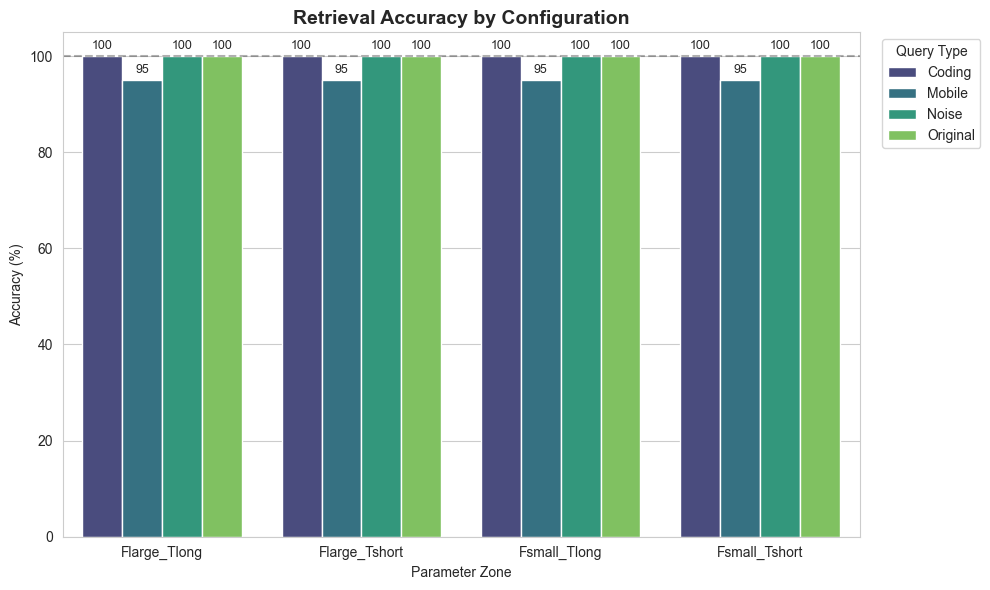

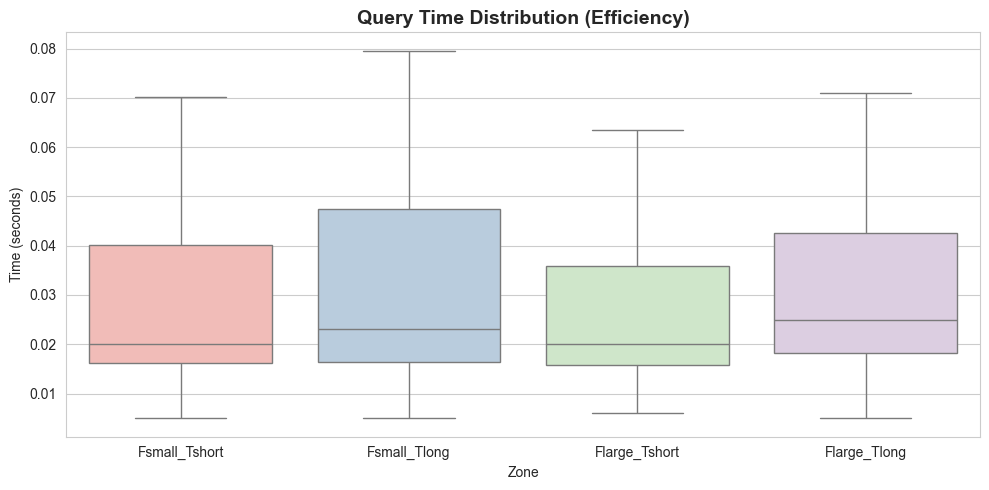

In [47]:
# =============================================================================
# TASK 2 & TASK 4: RETRIEVAL EXPERIMENTS & REPORTING (FINAL & FIXED)
# =============================================================================

import os
import glob
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tqdm.auto import tqdm

# ---------------------------------------------------------
# 1. KONFIGURATION
# ---------------------------------------------------------
BASE_PATH = r"C:\5Semester\IR\Milestone2\MS_2.2"

# Pfad zur Datenbank (Ergebnis aus Task 1)
PATH_TO_DB = os.path.join(BASE_PATH, "task1_hash_db", "hash_db.pkl")

# Ausgabe-Datei für die Ergebnisse
OUTPUT_CSV = os.path.join(BASE_PATH, "task2_retrieval_results.csv")

# Pfade zu den Query-Dateien (Deine Ordnerstruktur)
QUERY_ROOT = os.path.join(BASE_PATH, "music_queries", "music_queries")

QUERY_MAP = {
    "Coding":   os.path.join(QUERY_ROOT, "coding_artifact_queries"),
    "Mobile":   os.path.join(QUERY_ROOT, "mobile_queries"),
    "Noise":    os.path.join(QUERY_ROOT, "noise_queries"),
    "Original": os.path.join(QUERY_ROOT, "original_queries")
}

# ---------------------------------------------------------
# 2. MATCHING FUNKTIONEN
# ---------------------------------------------------------

def match_single_track(query_path, db, zone_name):
    """Führt das Matching für eine einzelne Datei durch."""
    meta = db["meta"]
    peak_params = meta["peak_params"]

    # Zone Config finden (z.B. Fsmall_Tlong)
    zone_config = next(z for z in meta["zones"] if z["name"] == zone_name)
    top_k = meta.get("top_k_targets")

    # A) Query laden & Spektrogramm
    # Wir laden die Query komplett (duration=None)
    Y_q = compute_spectrogram(query_path, Fs=meta["Fs"], N=meta["N"], H=meta["H"], duration=None)

    # B) Constellation Map (mit Parametern aus der DB!)
    C_q = compute_constellation_map(Y_q,
                                    dist_freq=peak_params["dist_freq"],
                                    dist_time=peak_params["dist_time"],
                                    thresh=peak_params["thresh"])

    # C) Peaks & Hashes
    peaks_q = extract_peaks(Y_q, C_q)
    query_hashes = generate_hashes_from_peaks(peaks_q, zone_config, top_k=top_k)

    # D) Suche im Inverted Index
    index = db["index"][zone_name]
    candidates = defaultdict(list)

    for h, t_query in query_hashes:
        if h in index:
            for p in index[h]:
                track_id, t_db = unpack_posting(p)
                candidates[track_id].append(t_db - t_query)

    # E) Scoring (Best Mode)
    best_track_name = "None"
    best_score = 0

    if candidates:
        track_scores = {}
        for tid, offsets in candidates.items():
            _, count = Counter(offsets).most_common(1)[0]
            track_scores[tid] = count

        best_tid = max(track_scores, key=track_scores.get)
        best_score = track_scores[best_tid]
        best_track_name = db["tracks"][best_tid]

    return best_track_name, best_score, len(query_hashes)

# ---------------------------------------------------------
# 3. BENCHMARK EXECUTION (MIT DEBUGGING & FORCE RERUN)
# ---------------------------------------------------------

def run_task2_benchmark(force_rerun=True): # <--- Standardmäßig neu berechnen
    # --- CHECK: Existiert die Datei schon? ---
    if os.path.exists(OUTPUT_CSV):
        if force_rerun:
            print(f"Old results found at {OUTPUT_CSV}. Deleting and recalculating...")
            os.remove(OUTPUT_CSV)
        else:
            print(f"File found: {OUTPUT_CSV}")
            print("Loading existing data and skip generation...")
            return pd.read_csv(OUTPUT_CSV)

    # --- Falls nicht, Berechnung starten ---
    print(f"Starting generation...")

    if not os.path.exists(PATH_TO_DB):
        print("ERROR: Database not found. Execute Task 1 first.")
        return None

    with open(PATH_TO_DB, 'rb') as f:
        db = pickle.load(f)

    zones = [z['name'] for z in db['meta']['zones']]
    results = []

    # Iteration über die definierten Kategorien-Ordner
    for category, folder_path in QUERY_MAP.items():
        if not os.path.exists(folder_path):
            print(f"WARNING: Folder not found: {folder_path}")
            continue

        query_files = []
        for ext in ['*.wav', '*.mp3', '*.m4a']:
            query_files.extend(glob.glob(os.path.join(folder_path, ext)))

        print(f"Category '{category}': {len(query_files)} Files found.")

        if not query_files: continue

        for zone in zones:
            # Nur für die erste Zone Debugging aktivieren, um Spam zu vermeiden
            debug_mode = (zone == zones[0])

            for q_path in tqdm(query_files, desc=f"{category} ({zone})", leave=False):
                q_name = os.path.basename(q_path)

                start_time = time.time()
                pred_name, score, num_hashes = match_single_track(q_path, db, zone)
                duration = time.time() - start_time

                is_correct = False

                # Variablen für Debugging vorbereiten
                q_id_extracted = "???"
                p_id_extracted = "???"

                if pred_name != "None":
                    try:
                        # 1. Endung entfernen
                        q_base = os.path.splitext(q_name)[0]
                        p_base = os.path.splitext(pred_name)[0]

                        # 2. ID extrahieren (Split am Unterstrich)
                        # ACHTUNG: Das nimmt an, dass die ID IMMER am Anfang steht (z.B. "1034_mobile")
                        q_id_extracted = q_base.split('_')[0]
                        p_id_extracted = p_base.split('_')[0]

                        # 3. Vergleich
                        if q_id_extracted == p_id_extracted:
                            is_correct = True
                    except Exception as e:
                        print(f"Error parsing: {e}")

                results.append({
                    "Zone": zone,
                    "Category": category,
                    "Query": q_name,
                    "Prediction": pred_name,
                    "Score": score,
                    "Hashes": num_hashes,
                    "Time": duration,
                    "Correct": is_correct
                })

    df = pd.DataFrame(results)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"\nResults finished and saved: {OUTPUT_CSV}")
    return df

# Starten mit force_rerun=True
df_results = run_task2_benchmark(force_rerun=True)

# ---------------------------------------------------------
# 4. REPORTING & VISUALISIERUNG (TASK 4)
# ---------------------------------------------------------

if df_results is not None and not df_results.empty:
    sns.set_style("whitegrid")

    print("\n=== Accuracy Summary Table ===")
    summary = df_results.groupby(["Zone", "Category"])["Correct"].mean().unstack() * 100
    display(summary.style.format("{:.1f}%").background_gradient(cmap="RdYlGn", vmin=0, vmax=100))

    # 2. PLOT: Accuracy Bar Chart
    plt.figure(figsize=(10, 6))

    # Daten für Plot vorbereiten
    acc_data = df_results.groupby(["Zone", "Category"])["Correct"].mean().reset_index()
    acc_data["Correct"] *= 100 # Prozent

    ax = sns.barplot(data=acc_data, x="Zone", y="Correct", hue="Category", palette="viridis")

    # Kosmetik
    ax.set_ylim(0, 105)
    ax.axhline(100, ls='--', color='black', alpha=0.3)
    ax.set_title("Retrieval Accuracy by Configuration", fontsize=14, fontweight='bold')
    ax.set_ylabel("Accuracy (%)")
    ax.set_xlabel("Parameter Zone")

    # Werte auf Balken schreiben
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', padding=3, fontsize=9)

    plt.legend(title="Query Type", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 3. PLOT: Query Time
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_results, x="Zone", y="Time", showfliers=False, palette="Pastel1")
    plt.title("Query Time Distribution (Efficiency)", fontsize=14, fontweight='bold')
    plt.ylabel("Time (seconds)")
    plt.tight_layout()
    plt.show()
else:
    print("Keine Daten zum Anzeigen.")